# Autoencoder (Semi-supervised)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [3]:
import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
# plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.set_context("notebook")


DATA_PATH = '../data/'
VAL_SPLITS = 4

In [4]:
from plot_utils import plot_confusion_matrix
from cv_utils import run_cv_f1
from cv_utils import plot_cv_roc
from cv_utils import plot_cv_roc_prc
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

For this part of the project, we will only work with the training set, that we will split again into train and validation to perform the hyperparameter tuning.

We will save the test set for the final part, when we have already tuned our hyperparameters.

In [5]:
df = pd.read_csv(os.path.join(DATA_PATH,'df_train.csv'))
df.drop(columns= df.columns[0:2],inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V24,V25,V26,V27,V28,Class,TimeScaled,TimeSin,TimeCos,AmountBC
0,-0.829392,1.118573,0.926038,1.163686,0.009824,0.527347,0.173370,0.723997,-0.638939,-0.162923,...,-0.298908,-0.060301,-0.217935,0.291312,0.120779,0,0.460069,-0.480989,0.876727,3.195062
1,-2.814527,1.613321,0.654307,0.581821,0.399491,0.730040,0.456233,-2.464347,0.654797,2.248682,...,-0.329526,-0.307374,-0.440007,-2.135657,0.011041,0,0.266395,-0.204567,-0.978853,3.125269
2,2.105028,-0.700400,-1.338043,-0.596395,-0.395217,-0.755050,-0.276951,-0.291562,-0.965418,1.107179,...,-0.278137,-0.040685,0.789267,-0.066054,-0.069956,0,0.762303,-0.153992,-0.988072,3.421235
3,2.205839,-1.023897,-1.270137,-0.950174,-0.868712,-0.975492,-0.475464,-0.280564,0.503713,0.448173,...,-0.041177,0.089158,1.105794,-0.066285,-0.079881,0,0.879740,-0.998227,0.059524,1.072145
4,2.027090,-0.778666,-1.552755,-0.558679,0.020939,-0.026071,-0.207810,-0.124288,-0.635953,0.817757,...,0.033477,-0.157992,-0.606327,-0.003931,-0.039868,0,0.821649,-0.783558,-0.621319,3.971490


## Preprocessing the data

Although we are always using cross validation with `VAL_SPLITS` folds, (in general, 4), here we are gonna set only one split in order to explore how the Autoencoder works and get intuition.

In [6]:
cv = StratifiedShuffleSplit(n_splits=1,test_size=0.15,random_state=0)

In [10]:
# In case we want to select a subset of features
# df_ = df[['Class','V9','V14','V16','V2','V3','V17']]
df_ = df[['Class','V4','V14','V16','V12','V3','V17']]
X = df_.drop(columns='Class').to_numpy()
y = df_['Class'].to_numpy()

for idx_t, idx_v in cv.split(X,y):
    X_train = X[idx_t]
    y_train = y[idx_t]
    X_val = X[idx_v]
    y_val = y[idx_v]
    
    # Now we need to erase the FRAUD cases on the TRAINING set  
    X_train_normal = X_train[y_train==0]

## Defining the model

In [11]:
# this is the size of our encoded representations
ENCODED_DIM = 2
INPUT_DIM = X.shape[1]

In [12]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LeakyReLU

def create_encoder(input_dim, encoded_dim):
    encoder = Sequential([
        Dense(32, input_shape=(input_dim,)),
        LeakyReLU(),
        Dense(16),
        LeakyReLU(),
        Dense(8),
        LeakyReLU(),
        Dense(encoded_dim)
    ], name='encoder')
    return encoder

def create_decoder(input_dim, encoded_dim):
    decoder = Sequential([
    Dense(8, input_shape=(encoded_dim,) ),
    LeakyReLU(),
    Dense(16),
    LeakyReLU(),
    Dense(8),
    LeakyReLU(),
    Dense(input_dim)
],name='decoder')
    return decoder



def create_autoencoder(input_dim, encoded_dim, return_encoder = True):
    encoder = create_encoder(input_dim,encoded_dim)
    decoder = create_decoder(input_dim,encoded_dim)
    inp = Input(shape=(INPUT_DIM,),name='Input_Layer')

    # a layer instance is callable on a tensor, and returns a tensor
    x_enc = encoder(inp)
    x_out = decoder(x_enc)


    # This creates a model that includes
    # the Input layer and three Dense layers
    autoencoder = Model(inputs=inp, outputs=x_out)
    if return_encoder:
        return autoencoder, encoder
    else:
        return autoencoder

In [13]:
autoencoder, encoder = create_autoencoder(INPUT_DIM,ENCODED_DIM)
print('ENCODER SUMMARY\n')
print(encoder.summary())
print('AUTOENCODER SUMMARY\n')
print(autoencoder.summary())

Instructions for updating:
Colocations handled automatically by placer.
ENCODER SUMMARY

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                224       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8)                 0         
_____________________________________________________

In [14]:
autoencoder.compile(optimizer='adam',
              loss='mean_squared_error')

## Training the model

In [15]:
autoencoder.fit(x=X_train_normal, y= X_train_normal,
                   batch_size=512,epochs=40, validation_split=0.1)  # starts training

Instructions for updating:
Use tf.cast instead.
Train on 184184 samples, validate on 20465 samples
Epoch 1/40
184184/184184 [==============================] - 2s 9us/step - loss: 0.6179 - val_loss: 0.4537
Epoch 2/40
184184/184184 [==============================] - 1s 4us/step - loss: 0.4595 - val_loss: 0.4329
Epoch 3/40
184184/184184 [==============================] - 1s 4us/step - loss: 0.4411 - val_loss: 0.4208
Epoch 4/40
184184/184184 [==============================] - 1s 4us/step - loss: 0.4235 - val_loss: 0.4015
Epoch 5/40
184184/184184 [==============================] - 1s 4us/step - loss: 0.4033 - val_loss: 0.3827
Epoch 6/40
184184/184184 [==============================] - 1s 4us/step - loss: 0.3900 - val_loss: 0.3725
Epoch 7/40
184184/184184 [==============================] - 1s 4us/step - loss: 0.3808 - val_loss: 0.3635
Epoch 8/40
184184/184184 [==============================] - 1s 4us/step - loss: 0.3734 - val_loss: 0.3575
Epoch 9/40
184184/184184 [===========================

## Testing

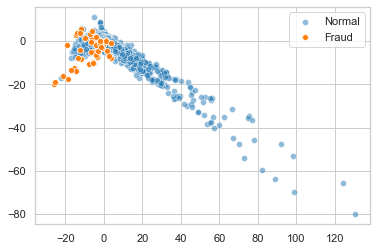

In [157]:
X_enc = encoder.predict(X_val)
X_enc_normal = X_enc[y_val==0]
X_enc_fraud = X_enc[y_val==1]
sns.scatterplot(x = X_enc_normal[:,0], y = X_enc_normal[:,1] ,label='Normal', alpha=0.5)
sns.scatterplot(x = X_enc_fraud[:,0], y = X_enc_fraud[:,1] ,label='Fraud')

In [159]:
X_out = autoencoder.predict(X_val)
print(X_out.shape)

(36176, 6)


In [160]:
X_val.shape

(36176, 6)

In [161]:
distances = np.sum((X_out-X_val)**2,axis=1)

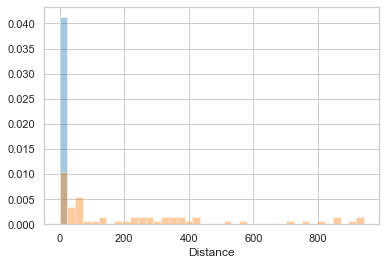

In [162]:
bins = np.linspace(0,np.max(distances),40)
sns.distplot(distances[y_val==0],label='Normal',kde=False, 
             bins=bins, norm_hist=True, axlabel='Distance')
sns.distplot(distances[y_val==1],label='Fraud',kde=False, bins=bins, norm_hist=True)

(0, 100)

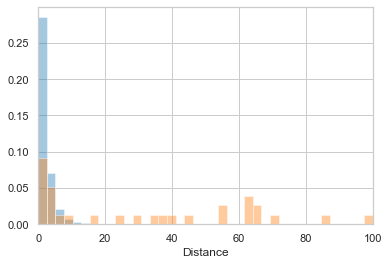

In [163]:
bins = np.linspace(0,100,40)
sns.distplot(distances[y_val==0],label='Normal',kde=False, 
             bins=bins, norm_hist=True, axlabel='Distance')
sns.distplot(distances[y_val==1],label='Fraud',kde=False, bins=bins, norm_hist=True)
plt.xlim((0,100))

## Validating the model

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score

In [20]:
def clf_autoencoder(X,autoencoder,threshold):
    """
    Classifier based in the autoencoder.
    A datapoint is a nomaly if the distance of the original points
    and the result of the autoencoder is greater than the threshold.
    """
    X_out = autoencoder.predict(X)
    distances = np.sum((X_out-X)**2,axis=1).reshape((-1,1))
    # y_pred = 1 if it is anomaly
    y_pred = 1.*(distances > threshold )
    return y_pred

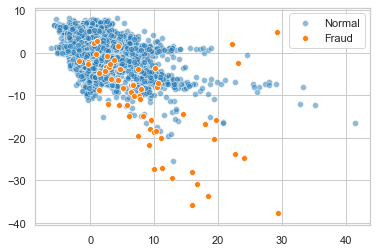

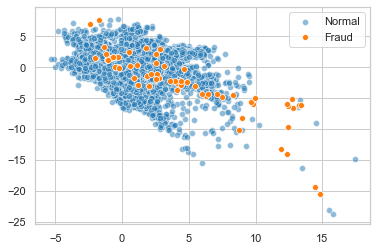

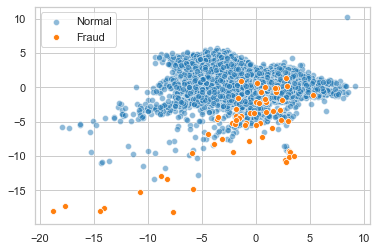

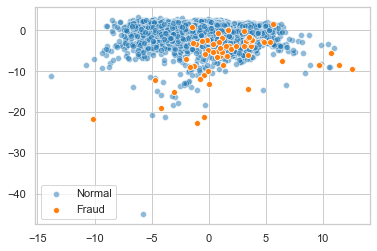

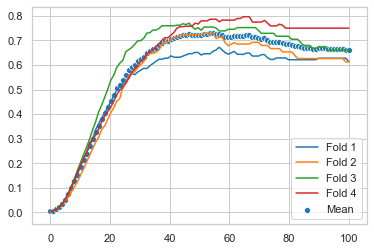

F1 max = 0.731 at threshold = 54.545


In [21]:
cv = StratifiedShuffleSplit(n_splits=VAL_SPLITS,test_size=0.15,random_state=0)
# Thresholds to validate
thresholds = np.linspace(0,100,100)
# List with the f1 of all the thresholds at each validation fold
f1_all = [] 
for i,(idx_t, idx_v) in enumerate(cv.split(X,y)):
    X_train = X[idx_t]
    y_train = y[idx_t]
    X_val = X[idx_v]
    y_val = y[idx_v]
    # Now we need to erase the FRAUD cases on the TRAINING set  
    X_train_normal = X_train[y_train==0]
    
    # Train the autoencoder
    autoencoder, encoder = create_autoencoder(INPUT_DIM,ENCODED_DIM)
    autoencoder.compile(optimizer='adam',
              loss='mean_squared_error')
    autoencoder.fit(x=X_train_normal, y= X_train_normal,
                   batch_size=512,epochs=30, shuffle=True,
                   verbose=0)  # starts training
    
    # Plot of the validation set in the embedding space
    X_enc = encoder.predict(X_val)
    X_enc_normal = X_enc[y_val==0]
    X_enc_fraud = X_enc[y_val==1]
    sns.scatterplot(x = X_enc_normal[:,0], y = X_enc_normal[:,1] ,label='Normal', alpha=0.5)
    sns.scatterplot(x = X_enc_fraud[:,0], y = X_enc_fraud[:,1] ,label='Fraud')
    plt.show()
    
    # Transformation of the points through the autoencoder 
    # and calculate the predictions
    y_preds=clf_autoencoder(X_val,autoencoder,thresholds)
    
    metrics_f1 = np.array([ f1_score(y_val,y_pred) for y_pred in y_preds.T  ])
    f1_all.append(metrics_f1)
    
    # Save the models into files for future use
    autoencoder.save('autoencoder_fold_'+str(i+1)+'.h5')
    encoder.save('encoder_fold_'+str(i+1)+'.h5')
    del(autoencoder,encoder)

f1_mean = np.mean(f1_all,axis=0) 
# Plot of F1-Threshold curves
for i,f1_fold in enumerate(f1_all):
    sns.lineplot(thresholds,f1_fold, label='Fold '+str(i+1))
sns.scatterplot(thresholds,f1_mean,label='Mean')
plt.show()
f1_opt = f1_mean.max()
threshold_opt = thresholds[np.argmax(f1_mean)]
print('F1 max = {:.3f} at threshold = {:.3f}'.format(f1_opt,threshold_opt))